In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from chinese_calendar import is_workday,is_holiday
import chinese_calendar as calendar 
import time,datetime
from scipy import stats 

In [3]:
#安装中文日历包
! pip install chinese_calendar

活动代码页: 936


# 数据处理

## 数据加载

In [4]:
#配置参数
train_path="order_train0.csv"
predict_path="predict_sku0.csv"

In [5]:
#读取CSV文件函数
def readCSV(filepath):
    C=pd.read_csv(filepath)
    dataF=pd.DataFrame(C)
    return dataF

In [6]:
#加载数据
train_data=readCSV(train_path)#训练集
predict_data=readCSV(predict_path)#测试集

In [7]:
#备份原始数据
train_data_copy=train_data.copy()
predict_data_copy=train_data.copy()

# 数据清洗

In [8]:
#查看训练集数据概况
train_data.describe()

,sales_region_code,item_code,first_cate_code,second_cate_code,item_price,ord_qty
count,59769.000000,59769.000000,59769.000000,59769.000000,59769.000000,59769.000000
mean,102.895581,21005.448560,304.937325,406.440295,1074.334474,91.443139
std,1.500799,592.082875,2.007037,3.107452,966.881714,195.407986
min,101.000000,20001.000000,301.000000,401.000000,1.000000,1.000000
25%,102.000000,20512.000000,303.000000,404.000000,597.000000,10.000000
50%,103.000000,20973.000000,306.000000,407.000000,880.280000,29.000000
75%,105.000000,21518.000000,306.000000,408.000000,1291.000000,101.000000
max,105.000000,22084.000000,308.000000,412.000000,47911.000000,12480.000000


### 缺失值查看
通过结果可见没有缺失值

In [9]:
#缺失值查看
print("训练集数据缺失情况")
print(train_data.isnull().sum())#统计有几个缺失值
print("验证集数据缺失情况")
print(predict_data.isnull().sum())#统计有几个缺失值

训练集数据缺失情况
order_date           0
sales_region_code    0
item_code            0
first_cate_code      0
second_cate_code     0
sales_chan_name      0
item_price           0
ord_qty              0
dtype: int64
验证集数据缺失情况
sales_region_code    0
item_code            0
first_cate_code      0
second_cate_code     0
dtype: int64


## 增加特征
将第一列的日期提取出年月日季节

In [10]:
#判断是否是周末
def isWeekend(days):
    res=[]
    for day in days:
        if(day==6 or day==7):
            res.append(1)
        else:
            res.append(0)
    return res
#判断是否是节假日
def isHoliday(dateList):
    res=[]
    for date in dateList:
        if(is_holiday(date)):
            res.append(1)
        else:
            res.append(0)
    return res
#销售方式转化
# 1代表线上 0代表线下
def salesChannel(channels):
    chan_dict={'offline':0,'online':1}
    res=[]
    for channel in channels:
        res.append(chan_dict[channel])
    return res
#季节
def season(dateList):
    season_dict={'spring':1,'summer':2,'fall':3,'winter':4}#季节
    res=[]
    for date in dateList:
        if(date in [3,4,5]):
            res.append(season_dict['spring']) #春天
        elif(date in [6,7,8]):
            res.append(season_dict['summer']) #夏天
        elif(date in [9,10,11]):
            res.append(season_dict['fall']) #秋天
        else:
            res.append(season_dict['winter']) #冬天
    return res

In [11]:

#将第一列先转化为datetime格式
datelist=pd.DataFrame({'date': pd.to_datetime(train_data['order_date'])})
train_data['order_date']=datelist

#提取年月日
train_data['year']=train_data.order_date.dt.year#年份
train_data['month']=train_data.order_date.dt.month#月份
train_data['day']=train_data.order_date.dt.day#日
train_data['day_of_week']=train_data.order_date.dt.day_of_week#每周第几天
train_data['is_weekend']=isWeekend(train_data['day_of_week'])#是否是周末
train_data['is_holiday']=isHoliday(train_data['order_date'])#判断是否是节假日
train_data['sales_chan']=salesChannel(train_data['sales_chan_name'])#销售方式转化，线下：0，线上：1
train_data['season']=season(train_data['month'])#季节season_dict={'spring':1,'summer':2,'fall':3,'winter':4}

train_data.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,year,month,day,day_of_week,is_weekend,is_holiday,sales_chan,season
0,2015-09-02,104,20028,301,405,offline,1005.0,11,2015,9,2,2,0,0,0,3
1,2015-09-03,102,20354,303,401,offline,1420.0,64,2015,9,3,3,0,1,0,3
2,2015-09-04,101,20586,306,407,offline,978.0,7,2015,9,4,4,0,1,0,3
3,2015-09-04,101,20230,306,407,offline,864.0,66,2015,9,4,4,0,1,0,3
4,2015-09-04,105,21619,306,402,online,274.0,102,2015,9,4,4,0,1,1,3


In [54]:
#将需求量调整到最后一列
ord=list(train_data['ord_qty'])
train_data=train_data.drop('ord_qty',axis=1)
train_data['ord_qty']=ord
train_data.head()



In [ ]:
#保存到文件中
train_data.to_csv("train_csv_4.04.csv",index=False)

## 数据标准化
减少不同特征间的量纲差距

### 销售价格的处理

In [13]:
#读取增加特征后的数据
train_data=pd.read_csv("train_csv_4.04.csv")
train_data.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,year,month,day,day_of_week,is_weekend,is_holiday,sales_chan,season
0,2015-09-02,104,20028,301,405,offline,1005.0,11,2015,9,2,2,0,0,0,3
1,2015-09-03,102,20354,303,401,offline,1420.0,64,2015,9,3,3,0,1,0,3
2,2015-09-04,101,20586,306,407,offline,978.0,7,2015,9,4,4,0,1,0,3
3,2015-09-04,101,20230,306,407,offline,864.0,66,2015,9,4,4,0,1,0,3
4,2015-09-04,105,21619,306,402,online,274.0,102,2015,9,4,4,0,1,1,3


In [29]:
#销售价格的处理
item_order=np.array(train_data['ord_qty'])
item_prices=np.array(train_data['item_price'])


In [55]:
def isNorm(data):
    
    m=data.mean()
    std=data.std()
    print(m,std)
    res=stats.kstest(data,'norm',(m,std))
    return res

In [56]:
#验证销售价格与销售需求量是否符合正态分布

print("销售价格的正态性检验:\n",isNorm(item_prices))
print("销售价格的正态性检验:\n",isNorm(item_order))
#不符合正态分布

1074.3344743368802 966.8736255348405
销售价格的正态性检验:
 KstestResult(statistic=0.1656569575595921, pvalue=0.0)
91.44313942010072 195.40635158418945
销售价格的正态性检验:
 KstestResult(statistic=0.32173721084863227, pvalue=0.0)


(array([1.790e+02, 8.120e+02, 1.984e+03, 2.864e+03, 3.189e+03, 5.023e+03,
        4.594e+03, 5.329e+03, 5.006e+03, 4.743e+03, 4.131e+03, 3.108e+03,
        2.837e+03, 1.977e+03, 2.098e+03, 1.883e+03, 1.503e+03, 8.850e+02,
        7.990e+02, 5.370e+02, 6.770e+02, 4.760e+02, 7.690e+02, 5.100e+02,
        5.400e+02, 4.550e+02, 4.220e+02, 2.600e+02, 4.190e+02, 2.140e+02,
        1.310e+02, 2.130e+02, 4.500e+01, 6.700e+01, 8.800e+01, 8.100e+01,
        8.600e+01, 9.400e+01, 6.500e+01, 2.400e+01, 1.700e+01, 6.200e+01,
        3.900e+01, 3.400e+01, 1.800e+01, 2.400e+01, 2.200e+01, 2.700e+01,
        3.300e+01, 2.200e+01, 9.000e+00, 1.300e+01, 3.200e+01, 2.000e+00,
        3.000e+00, 3.000e+00, 0.000e+00, 1.500e+01, 1.100e+01, 8.000e+00,
        4.000e+00, 4.000e+00, 3.300e+01, 4.000e+00, 1.100e+01, 2.000e+01,
        1.600e+01, 3.800e+01, 1.000e+00, 0.000e+00, 1.000e+01, 2.500e+01,
        3.000e+00, 5.000e+00, 7.000e+00, 1.000e+00, 3.000e+00, 7.000e+00,
        0.000e+00, 0.000e+00, 4.000e+0

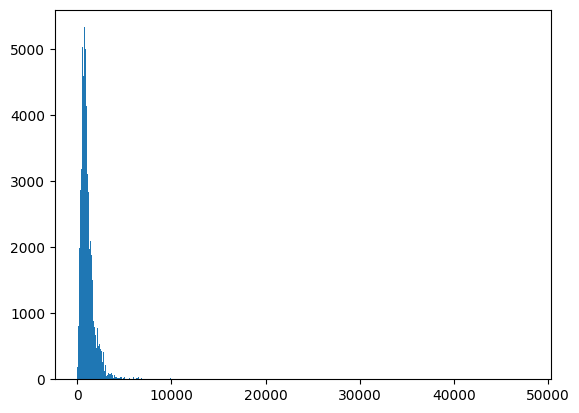

In [53]:
plt.hist(item_prices,bins=500)